In [1]:
from IPython.display import Image
from pathlib import Path
from bs4 import BeautifulSoup, Tag
from typing import Counter
from dataclasses import dataclass
from shapely.geometry import Polygon

import random
import geopandas as gpd
import networkx as nx

In [2]:
data_dir = Path('../data/raw/cubicasa5k/')
plan_dirs = list(data_dir.glob('**/model.svg'))

# Data Visualization

In [3]:
ex = random.choice(plan_dirs)
Image(url = ex, height = 500)

In [4]:
ex_bs = BeautifulSoup(ex.read_text(), 'xml')
str(ex_bs)[:500]

'<?xml version="1.0" encoding="utf-8"?>\n<svg height="1369.6700439453125" id="temp" version="1.1" viewBox="0 0 959.7100524902344 1369.6700439453125" width="959.7100524902344" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><desc>Powered by CubiCasa</desc><defs/><g class="Model v1-1" id="Model"><g class="Floor"><g class="Floorplan Floor-1" id="Floor-1"><g class="Space Bedroom" fill="#ffffff" id="54b17949-5218-468d-bed7-3d2a913741dc" stroke="#ffffff" style="fill-opacity'

In [5]:
SPACE_NAME_PREFIX = 'Space '
def derive_space_from_bs(tag: Tag):
    name = tag['class'][len(SPACE_NAME_PREFIX):]
    id = tag['id']

    points_str = tag.find('polygon')['points'].strip()
    points = [[float(x) for x in point.split(',')] for point in points_str.split(' ')]
    poly = Polygon(points)

    return name, id, poly

Bedroom


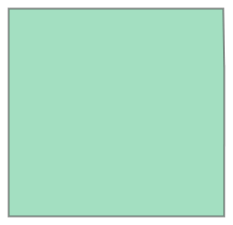

In [6]:
ex_bs_rooms = ex_bs.select('.Space')
name, id, poly = derive_space_from_bs(random.choice(ex_bs_rooms))
print(name)
poly

In [7]:
ex_rooms: gpd.GeoDataFrame = gpd.GeoDataFrame([
    {
        'geometry': poly,
        'id': id,
        'name': name,
    }
    for name, id, poly in (
        derive_space_from_bs(tag) for tag in ex_bs.select('.Space')
    )
]).set_index('id')
ex_rooms.head()

,geometry,name
id,,
54b17949-5218-468d-bed7-3d2a913741dc,"POLYGON ((432.650 744.650, 432.720 744.650, 43...",Bedroom
c0b11c80-9dba-4a71-8ed4-b341886d89dd,"POLYGON ((431.720 1089.160, 216.580 1089.160, ...",Kitchen
14b4dbe3-f89c-4d71-8f33-c7605865be98,"POLYGON ((432.650 881.940, 431.720 881.940, 43...",Undefined
b4d7e06a-f9e2-4269-a691-cfae8deabca5,"POLYGON ((925.650 1089.160, 447.650 1089.160, ...",Room
11a53f82-ef31-4b56-a112-745fb578d4d4,"POLYGON ((432.650 1293.150, 216.580 1293.150, ...",Bedroom


<AxesSubplot: >

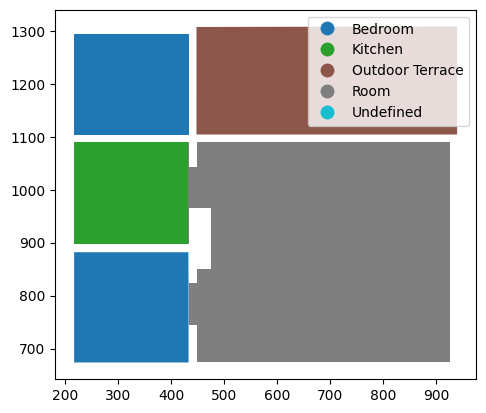

In [8]:
ex_rooms.plot(column='name', legend=True)

# Adjacency Detection

In [9]:
def generate_graph(df: gpd.GeoDataFrame, buffer_pct = .03):
    """Turns a DataFrame of rooms into an adjacency graph"""
    minX, minY, maxX, maxY = df.total_bounds
    buffer_amt = (maxX - minX) * buffer_pct

    buffer_df = gpd.GeoDataFrame(geometry=df.buffer(buffer_amt))
    
    adjacency_df = df.sjoin(buffer_df)
    same_rooms = adjacency_df.index == adjacency_df.index_right
    adjacency_df = adjacency_df[~same_rooms]

    graph = nx.Graph()
    graph.add_nodes_from(df.index)
    # Possible improvement: weight edges by their distance
    graph.add_edges_from(adjacency_df['index_right'].items())
    return graph

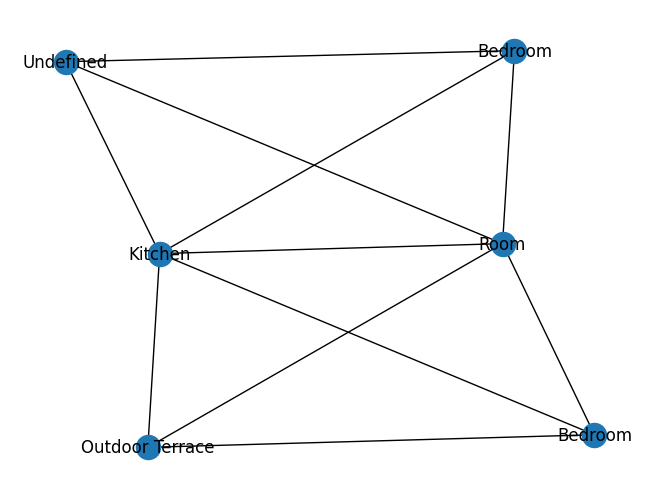

In [10]:
ex_graph = generate_graph(ex_rooms, .07)
nx.draw(ex_graph, labels=ex_rooms['name'].to_dict())